# Feature Sets

**Learning Objective:**
    Create a minimal set of features that perform as well as more complex feature set.

So far we've thrown all our features into the model. Models with fewer features use fewer resources and are easier to maintain. Let's see if we can build a model on a minimal dataset of housing features that will perform equally as well as one that uses all features in the dataset.

In [9]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index)
)

In [10]:
def preprocess_features(california_housing_dataframe):
    """
    Prepares input features from California housing data set.
    Args:
        california_housing_dataframe: A Pandas DataFrame expected to contain data 
        from the California housing data set.
    Returns:
        A DataFrame that contains the features to be used for the model, including
        synthetic features.
    """
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    # Create a synthetic feature.
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e., labels) from California housing data set.
    Args:
        california_housing_dataframe: A Pandas DataFrame expected to contain data
        from the California housing data set.
    Returns:
        A DataFrame that contains the target feature.
    """
    output_targets = pd.DataFrame()
    # Scale the target to be in units of thousands of dollars.
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [11]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.6,2642.7,539.1,1429.9,501.0,3.9,2.0
std,2.1,2.0,12.6,2204.0,423.3,1140.2,386.8,1.9,1.1
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1459.0,297.0,788.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2128.5,434.0,1163.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3136.2,648.0,1713.0,605.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.5,2645.9,540.1,1428.7,501.7,3.9,2.0
std,2.1,2.0,12.6,2121.4,417.1,1166.2,379.0,1.9,1.3
min,32.6,-124.3,2.0,11.0,3.0,3.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1466.8,296.0,792.0,281.0,2.6,1.5
50%,34.3,-118.5,29.0,2126.0,434.0,1175.0,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3184.2,650.0,1742.0,606.0,4.8,2.3
max,41.9,-114.5,52.0,30405.0,4819.0,35682.0,4769.0,15.0,52.0


Training targets summary:


,median_house_value
count,12000.0
mean,207.8
std,116.1
min,15.0
25%,119.6
50%,181.1
75%,266.2
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.1
std,115.8
min,15.0
25%,119.2
50%,178.6
75%,262.5
max,500.0


# Task 1: Develop a good feature set

**What's the best performance you get with only 2 or 3 features?**

A **correlation matrix** shows pairwise correlations, both for each feature compared to the target and for each features compared to each other features. We're going to use Pearson correlation coefficient. 

Correlation values have following meanings:
* -1 : perfect negative correlation
* 0 : no correlation
* 1 : perfect positive correlation

In [12]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]

correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.2,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.1,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.3,0.7
rooms_per_person,0.2,-0.1,-0.1,0.1,0.1,-0.1,-0.0,0.3,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


Features with strong positive or negative correlation with the target will add information to our model. We can use correlation matrix to find such correlated features. 

We'd like to have featuers that aren't so strongly correlated with each other, so that they add independent information. 
Use this information to try removing features. You can also try synthetic features, such as ratio of two raw features.

In [13]:
def construct_feature_columns(input_features):
    """ Construct the TensorFlow Feature columns.
    
    Args:
        input_features: The names of the numerical input features to use.
    Returns:
        A set of feature  columns
    """
    return set([tf.feature_column.numeric_column(my_feature)
               for my_feature in input_features])

In [14]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """ Trains linear regression model of multiple features.
    
    Args:
        features: pandas dataframe of features
        targets: pandas dataframe of targets
        batch_size: Size of batches to be passed to the model
        shuffle: True or False, whether to shuffle the data
        num_epochs: Number of epochs for which data should be repeated. None = repeat indefinately.
    Returns:
        Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into dict of np arrays:
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets)) # WARNING: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [18]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """ Train a Linear Regression model of multiple features.
    
    In addition to training, this function also prints training progress information, 
    as well as a lot of the training and loss over time.
    
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
            consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        training_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for validation.
    
    Returns:
        A `LinearRegressor` object trained on training data.
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    # Create a linear regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = construct_feature_columns(training_examples),
        optimizer = my_optimizer
    )
    
    # 1. Create a input function
    training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value"], 
        batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value"], 
        num_epochs=1, 
        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples, 
        validation_targets["median_house_value"],
        num_epochs=1,
        shuffle=False)
    
    # Train the model, but do it inside the loop so that we can periodically asses loss metrics
    print("Training model...")
    print("RMSE (on Training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model starting from the prior state
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period,
        )
        # 2. Take a break and compute predictions
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets)
        )
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets)
        )
        
        # Occasionally print the current loss
        print(" period %02d: %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    
    print("Model training finished.")
    
    # Output the graph loss
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    _ = plt.show()
    
    return linear_regressor

Training model...
RMSE (on Training data):
 period 00: 172.53
 period 01: 115.41
 period 02: 89.73
 period 03: 85.35
 period 04: 84.71
 period 05: 84.70
 period 06: 85.46
 period 07: 84.42
 period 08: 85.69
 period 09: 85.43
Model training finished.


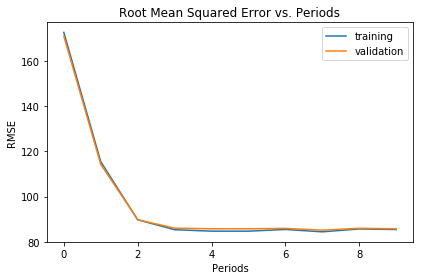

In [19]:
# Rajat's solution
minimal_features = ["median_income", "rooms_per_person"]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

train_model(
    learning_rate=0.1,
    steps=300,
    batch_size=4,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets
)

Training model...
RMSE (on Training data):
 period 00: 166.04
 period 01: 121.54
 period 02: 117.43
 period 03: 116.94
 period 04: 115.79
 period 05: 115.35
 period 06: 114.74
 period 07: 114.50
 period 08: 114.08
 period 09: 113.29
Model training finished.


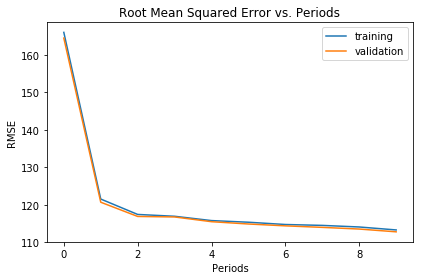

In [20]:
# Google's solution
minimal_features = [
  "median_income",
  "latitude",
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

# Task 2: Let's make better use of Latitude/Rooms_Per_Person

Plotting Latitude vs Median House Price shows that there really isn't a linear relationship there.

Instead couple of peaks which roughly corresponds to Los Angeles and San Fransisco.

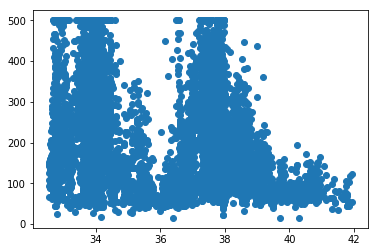

In [21]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

While on the other hand lets see relationship with rooms per person and median income

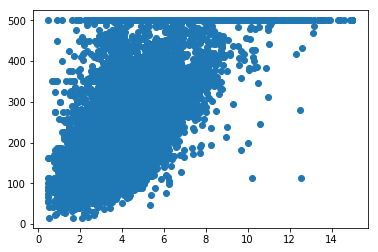

In [24]:
plt.scatter(training_examples["median_income"], training_targets["median_house_value"])

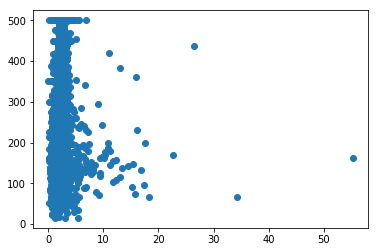

In [25]:
plt.scatter(training_examples["rooms_per_person"], training_targets["median_house_value"])

## Binning

In [31]:
LATITUDE_RANGES = zip(range(32, 44), range(33, 45))

def select_and_transform_features(source_df):
    selected_examples = pd.DataFrame()
    selected_examples["median_income"] = source_df["median_income"]
    for r in LATITUDE_RANGES:
        selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
            lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
    return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

In [32]:
_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on Training data):


ValueError: Feature latitude_32_to_33 is not in features dictionary.